<a href="https://colab.research.google.com/github/yuni1218/GIthubWorkshop/blob/main/dev_differentiable_smhm_tng_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing a differentiable stellar-to-halo-mass relation with JAX

This notebook shows how to do the following things from scratch:
1. Implement a differentiable SMHM relation with JAX
2. Implement a differentiable loss function
3. Compute the derivative of a loss function with JAX
4. Run your own gradient descent to optimize the model

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jnp
from jax import jit as jjit
from jax import grad

In [ ]:
# TNG data can be found here:
# https://drive.google.com/file/d/1c0ifhKRjaNcUfCWhP3DpMHimhNuTBEKV/view?usp=sharing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving tng_smhm.txt to tng_smhm.txt


In [3]:
X = np.loadtxt("tng_smhm.txt", delimiter=',')

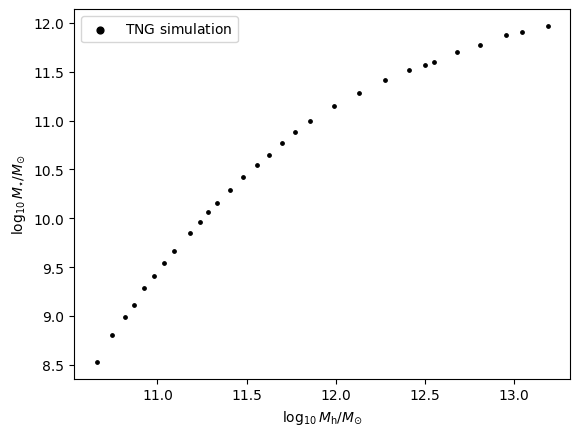

In [4]:
logmh_tng = X[:, 0]
ratio = X[:, 1]
logsm_tng = np.log10(ratio*10**logmh_tng)

fig, ax = plt.subplots(1, 1)
xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm h}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\star}/M_{\odot}$')

__=ax.scatter(logmh_tng, logsm_tng, s=6, color='k', label=r'${\rm TNG\ simulation}$')
leg = ax.legend(markerscale=2)

In [5]:
from jax import jit as jjit
from jax import numpy as jnp
from jax import nn

XTP = 12.0

@jjit
def predict_logsm(params, x):
    logsm_pred = _sig_slope(x, XTP, *params)
    return logsm_pred

@jjit
def _sigmoid(x, x0, k, ylo, yhi):
    height_diff = yhi - ylo
    return ylo + height_diff * nn.sigmoid(k * (x - x0))

@jjit
def _sig_slope(x, xtp, ytp, x0, slope_k, lo, hi):
    slope = _sigmoid(x, x0, slope_k, lo, hi)
    return ytp + slope * (x - xtp)

#### Inspect an initial guess for the model parameters

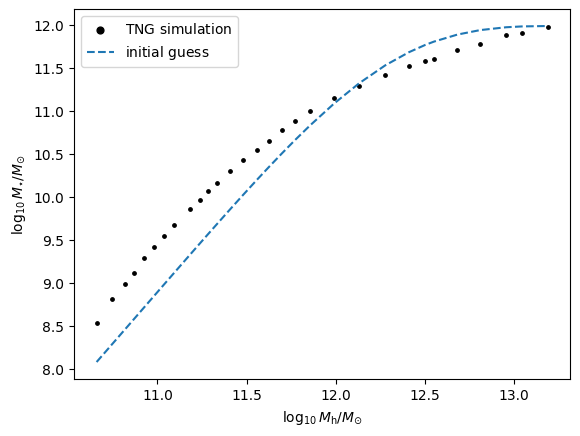

In [6]:
ytp, x0, slope_k, lo, hi = 11.1, 12.5, 2.0, 2.3, 0.35
P_INIT = np.array((ytp, x0, slope_k, lo, hi))
ypred_init = predict_logsm(P_INIT, logmh_tng)

fig, ax = plt.subplots(1, 1)
xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm h}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\star}/M_{\odot}$')

__=ax.scatter(logmh_tng, logsm_tng, s=6, color='k', label=r'${\rm TNG\ simulation}$')
__=ax.plot(logmh_tng, ypred_init, '--', label=r'${\rm initial\ guess}$')

leg = ax.legend(markerscale=2)

### Define simple loss function based on MAE

In [7]:
@jjit
def _mae(pred, target):
    diff = pred-target
    return jnp.mean(jnp.abs(diff))

@jjit
def log_smhm_loss(params, x_target, y_target):
    pred = predict_logsm(params, x_target)
    return _mae(pred, y_target)

In [10]:
loss_init = log_smhm_loss(P_INIT, logmh_tng, logsm_tng)
print(loss_init) #derivative of loss

0.3261567


### Define _derivative_ of loss function with JAX

In [9]:
from jax import grad

log_smhm_loss_grad = jjit(grad(log_smhm_loss, argnums=0))

#### Wait, what?

JAX is a library for automatic differentiation. If you implement your function in JAX, then you can programatically compute its derivative using the magic of autodiff. Let's try evaluating the gradient to see what we find.

In [11]:
log_smhm_loss_grad(P_INIT, logmh_tng, logsm_tng)

Array([-0.33333334,  0.29080933,  0.04376939,  0.5283908 ,  0.17145751],      dtype=float32)

We have a 5-parameter model, and our gradient is a 5-element array. So far, so good! Now let's pass our gradient function to scipy and use the BFGS algorithm to optimize.

In [14]:
from scipy.optimize import minimize

res = minimize(log_smhm_loss, P_INIT, args=(logmh_tng, logsm_tng), jac=log_smhm_loss_grad, method='BFGS') #what is the best optimizer
ypred_best = predict_logsm(res.x, logmh_tng)

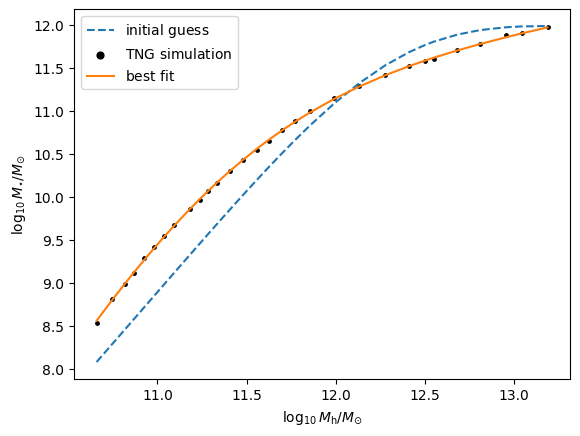

In [15]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logmh_tng, ypred_init, '--', label=r'${\rm initial\ guess}$')

__=ax.scatter(logmh_tng, logsm_tng, s=6, color='k', label=r'${\rm TNG\ simulation}$')

__=ax.plot(logmh_tng, ypred_best, label=r'${\rm best\ fit}$')

leg = ax.legend(markerscale=2)

xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm h}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\star}/M_{\odot}$')

# Roll your own gradient descent!
Now let's ditch scipy and run our own gradient descent from scratch. We have an exact gradient from JAX, so we just take a succession of tiny steps in that direction.

First let's define one new function using `jax.value_and_grad` rather than `jax.grad`, which will help us examine our loss curve.

In [16]:
from jax import value_and_grad

log_smhm_loss_and_grad = jjit(value_and_grad(log_smhm_loss, argnums=0))

In [17]:
params = np.copy(P_INIT) #initial guess
learn_rate = 0.02 # The choice of learning rate depends on the problem
n_steps = 2_000 # The number of steps to convergence also depends on the problem
loss_collector = []
for i in range(n_steps):
  loss_i, grads_i = log_smhm_loss_and_grad(params, logmh_tng, logsm_tng)  # Recompute gradients
  params = params - grads_i*learn_rate  # update the parameters
  loss_collector.append(loss_i) # save the loss at each step to examine later #loss and gradiant

ypred_best2 = predict_logsm(params, logmh_tng)  # compute best-fit prediction

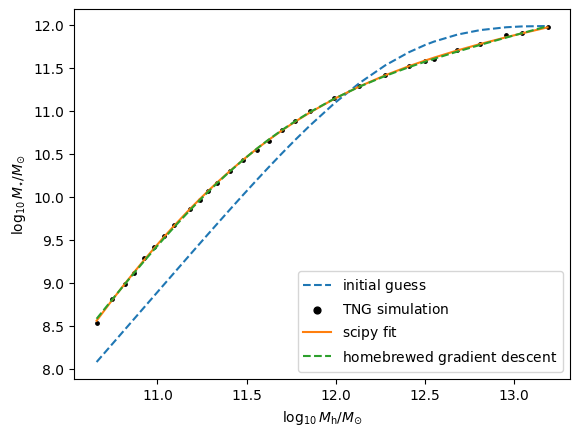

In [18]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logmh_tng, ypred_init, '--', label=r'${\rm initial\ guess}$')

__=ax.scatter(logmh_tng, logsm_tng, s=6, color='k', label=r'${\rm TNG\ simulation}$')

__=ax.plot(logmh_tng, ypred_best, label=r'${\rm scipy\ fit}$')
__=ax.plot(logmh_tng, ypred_best2, '--', label=r'${\rm homebrewed\ gradient\ descent}$')

leg = ax.legend(markerscale=2)

xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm h}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\star}/M_{\odot}$')

### Our homebrewed best-fit looks good!

All the same, it's always a good idea to inspect the loss curve to make sure the fit is converged.

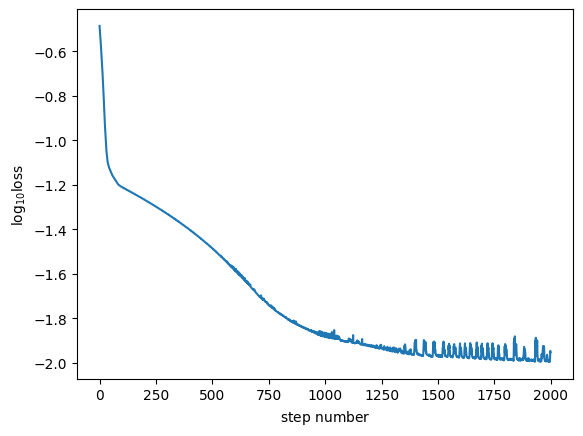

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_collector))

xlabel = ax.set_xlabel(r'${\rm step\ number}$')
ylabel = ax.set_ylabel(r'${\rm log_{10}loss}$')